### Note that these results rely on data stored in my WandB profile

In [1]:
import wandb
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix
import time
from utils.classes import get_model_outputs, calc_computational_efficiency_and_robustness

api = wandb.Api()
proj = api.project("geetakingle/TAPT_roberta")

pre_TAPT = {"jobType": "pre_TAPT_finetune"}
post_TAPT = {"jobType": "post_TAPT_finetune"}
DAPT_TAPT = {"jobType": None}
# runs = api.runs(
#     path="geetakingle/TAPT_roberta",
#     filters=post_TAPT
# )

best_pre_TAPT = "geetakingle/TAPT_roberta/sn5mbia2"
best_pre_TAPT_path = "models/distilroberta-base_base_finetuned_1682486148.pt"

best_post_TAPT = "geetakingle/TAPT_roberta/p02cnzi4"
best_post_TAPT_path = "models/TAPT_1682353322_finetuned_1682529211.pt"

best_post_DAPT = "geetakingle/TAPT_roberta/fja93jec"
best_post_DAPT_path = "models/TAPT_businessTAPT_1682554710_finetuned_1682825457.pt"

best_post_DAPT_TAPT = "geetakingle/TAPT_roberta/qgdwb1hp" # geetakingle/TAPT_roberta/soaq97ea
best_post_DAPT_TAPT_path = "models/DAPT_TAPT_1682693602_finetuned_1682836963.pt" #"models/DAPT_TAPT_1682693602_finetuned_1682707798.pt"

overfitted_pre_TAPT = "geetakingle/TAPT_roberta/svzlzr7u"
overfitted_pre_TAPT_path = "models/distilroberta-base_base_finetuned_1682630116.pt"

overfitted_post_TAPT = "geetakingle/TAPT_roberta/oaey36yo"
overfitted_post_TAPT_path = "models/TAPT_1682607636_finetuned_1682618928.pt"

best_TAPT_model = "geetakingle/TAPT_roberta/c3c70fve"
best_TAPT_model_path = "huggingface/TAPT_1682353322"

best_DAPT_TAPT_model = "geetakingle/TAPT_roberta/rvnh1beg"
best_DAPT_TAPT_model_path = "huggingface/DAPT_TAPT_1682693602"

best_DAPT_model = "geetakingle/TAPT_roberta/q7e1ykx0" 
best_DAPT_model_path = "huggingface/TAPT_businessTAPT_1682554710"


## Retrive all run histories

In [2]:
df_best_pre_TAPT = api.run(best_pre_TAPT).history()
df_best_post_TAPT = api.run(best_post_TAPT).history()
df_best_post_DAPT = api.run(best_post_DAPT).history()
df_best_post_DAPT_TAPT = api.run(best_post_DAPT_TAPT).history()
df_overfitted_pre_TAPT = api.run(overfitted_pre_TAPT).history()
df_overfitted_post_TAPT = api.run(overfitted_post_TAPT).history()
df_best_TAPT_model = api.run(best_TAPT_model).history()
df_best_DAPT_TAPT_model = api.run(best_DAPT_TAPT_model).history()
df_best_DAPT_model = api.run(best_DAPT_model).history()

'0': World
'1': Sports
'2': Business
'3': Sci/Tech

True label on ith (dim 0), predicted on jth (dim 1)

# Calculate Metrics

In [3]:
efficiency, robustness, num_params = calc_computational_efficiency_and_robustness(best_pre_TAPT_path)
print(f"Efficiency: {efficiency}, Robustness: {robustness}")
print(f"Total Params: {num_params}")

100%|██████████| 38/38 [00:19<00:00,  1.94it/s]

Efficiency: 4182915.285691847, Robustness: 0.9246052631578947
Total Params: 82121476


In [4]:
efficiency, robustness, _ = calc_computational_efficiency_and_robustness(best_post_TAPT_path)
print(f"Efficiency: {efficiency}, Robustness: {robustness}")

100%|██████████| 38/38 [00:18<00:00,  2.10it/s]

Efficiency: 4544883.431804284, Robustness: 0.9331578947368421


In [5]:
efficiency, robustness, _ = calc_computational_efficiency_and_robustness(best_post_DAPT_path)
print(f"Efficiency: {efficiency}, Robustness: {robustness}")

100%|██████████| 38/38 [00:18<00:00,  2.10it/s]

Efficiency: 4529560.701374502, Robustness: 0.9242105263157895


In [6]:
efficiency, robustness, _ = calc_computational_efficiency_and_robustness(best_post_DAPT_TAPT_path)
print(f"Efficiency: {efficiency}, Robustness: {robustness}")

100%|██████████| 38/38 [00:17<00:00,  2.11it/s]

Efficiency: 4565615.462559547, Robustness: 0.9306578947368421


In [15]:
efficiency, robustness, _ = calc_computational_efficiency_and_robustness(overfitted_pre_TAPT_path)
print(f"Efficiency: {efficiency}, Robustness: {robustness}")

100%|██████████| 38/38 [00:18<00:00,  2.06it/s]

Efficiency: 4459865.364042793, Robustness: 0.9263157894736842


In [8]:
efficiency, robustness, _ = calc_computational_efficiency_and_robustness(overfitted_post_TAPT_path)
print(f"Efficiency: {efficiency}, Robustness: {robustness}")

100%|██████████| 38/38 [00:18<00:00,  2.09it/s]

Efficiency: 4507919.634960871, Robustness: 0.9338157894736843


# Tuning and dealing with Overfitting
Increased batch size to 200, decreased LR, introduced linear decay of learning rate, decreased Adam momentum (Beta), early stopping in epochs, tuning dense layer capacity, dropout probability tuning

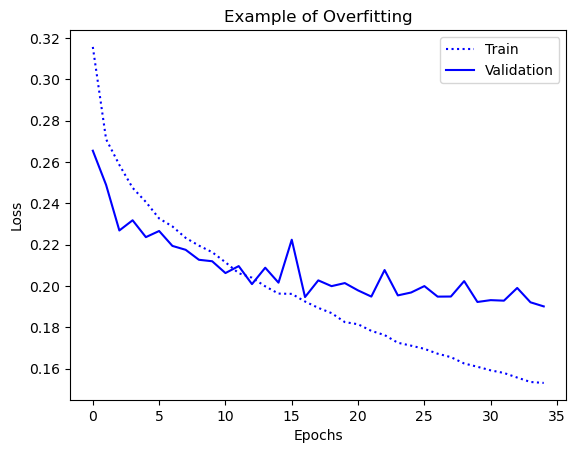

In [9]:
sns.lineplot(data=df_overfitted_post_TAPT, x='_step', y='Epoch Train loss', label="Train", color='blue', linestyle='dotted')
sns.lineplot(data=df_overfitted_post_TAPT, x='_step', y='Epoch Valid loss', label="Validation", color='blue')
plt.title("Example of Overfitting")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

## How does TAPT affect Classification?

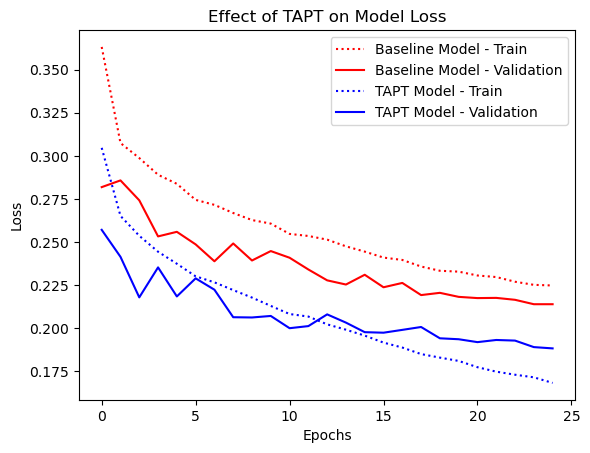

In [30]:
sns.lineplot(data=df_best_pre_TAPT, x='_step', y='Epoch Train loss', label="Baseline Model - Train", color='red', linestyle='dotted')
sns.lineplot(data=df_best_pre_TAPT, x='_step', y='Epoch Valid loss', label="Baseline Model - Validation", color='red')
sns.lineplot(data=df_best_post_TAPT, x='_step', y='Epoch Train loss', label="TAPT Model - Train", color='blue', linestyle='dotted')
sns.lineplot(data=df_best_post_TAPT, x='_step', y='Epoch Valid loss', label="TAPT Model - Validation", color='blue')
plt.title("Effect of TAPT on Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [16]:
print(f"Pre Acc: {df_best_pre_TAPT['Epoch Test Acc'].iloc[-1]}, Post Acc: {df_best_post_TAPT['Epoch Test Acc'].iloc[-1]}")
print(f"Acc diff: {100*(df_best_post_TAPT['Epoch Test Acc'].iloc[-1] - df_best_pre_TAPT['Epoch Test Acc'].iloc[-1])}")
print(f"Pre Loss: {df_best_pre_TAPT['Epoch Test loss'].iloc[-1]}, Post Loss: {df_best_post_TAPT['Epoch Test loss'].iloc[-1]}")
predicted, target = get_model_outputs(best_post_TAPT_path)
print(classification_report(predicted, target))
print(confusion_matrix(predicted, target))
print(multilabel_confusion_matrix(predicted, target))


Pre Acc: 0.924605263157895, Post Acc: 0.933157894736842
Acc diff: 0.8552631578946923
Pre Loss: 0.21698063533557088, Post Loss: 0.1941238312344802


100%|██████████| 38/38 [00:17<00:00,  2.17it/s]

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1883
           1       0.98      0.98      0.98      1912
           2       0.90      0.91      0.90      1878
           3       0.91      0.90      0.91      1927

    accuracy                           0.93      7600
   macro avg       0.93      0.93      0.93      7600
weighted avg       0.93      0.93      0.93      7600

[[1791   13   41   38]
 [  23 1867    9   13]
 [  51    8 1702  117]
 [  35   12  148 1732]]
[[[5608  109]
  [  92 1791]]

 [[5655   33]
  [  45 1867]]

 [[5524  198]
  [ 176 1702]]

 [[5505  168]
  [ 195 1732]]]


# How does DAPT affect Classification

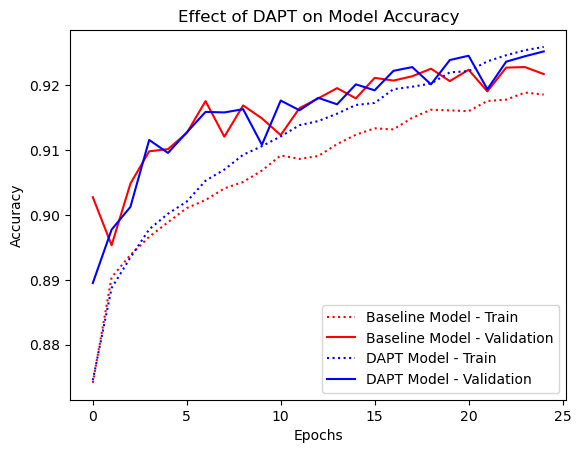

In [25]:
sns.lineplot(data=df_best_pre_TAPT, x='_step', y='Epoch Train Acc', label="Baseline Model - Train", color='red', linestyle='dotted')
sns.lineplot(data=df_best_pre_TAPT, x='_step', y='Epoch Valid Acc', label="Baseline Model - Validation", color='red')
sns.lineplot(data=df_best_post_DAPT, x='_step', y='Epoch Train Acc', label="DAPT Model - Train", color='blue', linestyle='dotted')
sns.lineplot(data=df_best_post_DAPT, x='_step', y='Epoch Valid Acc', label="DAPT Model - Validation", color='blue')
plt.title("Effect of DAPT on Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [27]:
print(f"Pre Acc: {df_best_pre_TAPT['Epoch Test Acc'].iloc[-1]}, Post Acc: {df_best_post_DAPT['Epoch Test Acc'].iloc[-1]}")
print(f"Acc diff: {100*(df_best_post_DAPT['Epoch Test Acc'].iloc[-1] - df_best_pre_TAPT['Epoch Test Acc'].iloc[-1])}")
print(f"Pre Loss: {df_best_pre_TAPT['Epoch Test loss'].iloc[-1]}, Post Loss: {df_best_post_DAPT['Epoch Test loss'].iloc[-1]}")
predicted, target = get_model_outputs(best_post_DAPT_path)
print(classification_report(predicted, target))
print(confusion_matrix(predicted, target))
print(multilabel_confusion_matrix(predicted, target))


Pre Acc: 0.924605263157895, Post Acc: 0.9242105263157896
Acc diff: -0.03947368421054476
Pre Loss: 0.21698063533557088, Post Loss: 0.21844858166418576


100%|██████████| 38/38 [00:18<00:00,  2.09it/s]

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      1875
           1       0.98      0.98      0.98      1909
           2       0.87      0.91      0.89      1829
           3       0.92      0.88      0.90      1987

    accuracy                           0.92      7600
   macro avg       0.92      0.92      0.92      7600
weighted avg       0.92      0.92      0.92      7600

[[1764   20   50   41]
 [  24 1862   13   10]
 [  60    6 1656  107]
 [  52   12  181 1742]]
[[[5589  136]
  [ 111 1764]]

 [[5653   38]
  [  47 1862]]

 [[5527  244]
  [ 173 1656]]

 [[5455  158]
  [ 245 1742]]]


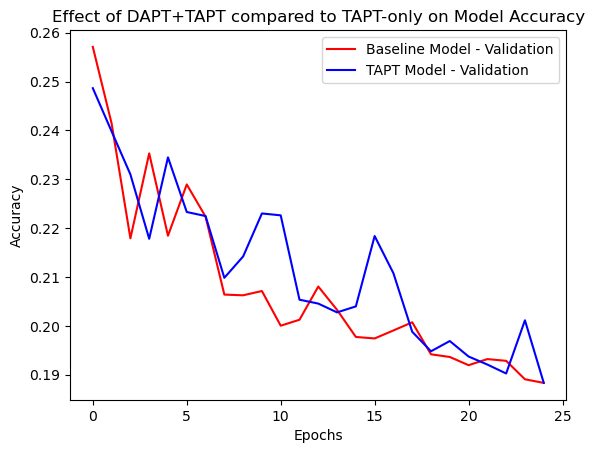

In [22]:
# sns.lineplot(data=df_best_post_TAPT, x='_step', y='Epoch Train Acc', label="Baseline Model - Train", color='red', linestyle='dotted')
sns.lineplot(data=df_best_post_TAPT, x='_step', y='Epoch Valid loss', label="Baseline Model - Validation", color='red')
# sns.lineplot(data=df_best_post_DAPT_TAPT, x='_step', y='Epoch Train Acc', label="TAPT Model - Train", color='blue', linestyle='dotted')
sns.lineplot(data=df_best_post_DAPT_TAPT, x='_step', y='Epoch Valid loss', label="TAPT Model - Validation", color='blue')
plt.title("Effect of DAPT+TAPT compared to TAPT-only on Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

### How does DAPT-only and TAPT-only affect the confusion matrix?

In [17]:
predicted, target = get_model_outputs(best_post_DAPT_path)
print(confusion_matrix(predicted, target))

100%|██████████| 38/38 [00:17<00:00,  2.14it/s]

[[1764   20   50   41]
 [  24 1862   13   10]
 [  60    6 1656  107]
 [  52   12  181 1742]]


In [18]:
predicted, target = get_model_outputs(best_post_TAPT_path)
print(confusion_matrix(predicted, target))

100%|██████████| 38/38 [00:17<00:00,  2.12it/s]

[[1791   13   41   38]
 [  23 1867    9   13]
 [  51    8 1702  117]
 [  35   12  148 1732]]
